In [1]:
#pip install gensim

In [111]:
import pandas as pd
import numpy as np
import gensim
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [22]:
data = pd.read_csv('data/Maddow_cleaned.tsv',sep='\t').drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [3]:
pew = pd.read_excel('data/Pew Issue Polling 2022.xlsx')

In [4]:
# Load the Google News Vectors model
# downloaded from here https://www.kaggle.com/datasets/leadbest/googlenewsvectorsnegative300 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)


### Example use 

In [5]:
# Define a text
text = "This is an example of a text for semantic analysis."

# Tokenize the text into words
words = word_tokenize(text)

# Get the vector representation of each word
vectors = [model[word] for word in words if word in model]

# Aggregate the word vectors to obtain a representation of the text as a whole
text_vector = sum(vectors) / len(vectors)


### Weighting the word vector by the TF-IDF score

In [6]:
# Convert the text data into a matrix of TF-IDF features
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data['transcript'].tolist())

# Weight the word vectors based on their TF-IDF scores
word_index = vectorizer.vocabulary_
word_vectors = np.zeros((len(word_index), 300))
for word, index in word_index.items():
    try:
        word_vectors[index, :] = model[word] * tfidf[0, index]
    except KeyError:
        pass


### Mean transcript word vector per transcript

In [43]:
# Initialize the matrix to store the document vectors
doc_vector_words = np.zeros((data.shape[0], 300))
doc_vector_avg = [] 

# Compute the document vectors as the mean of the weighted word vectors
for i, row in data.iterrows():
    words = row['transcript'].split()
    for word in words:
        if word in word_index:
            doc_vector_words[i, :] += word_vectors[word_index[word], :]
    doc_vector_words[i, :] /= len(words)
    doc_vecor_avg = doc_vector_avg.append(doc_vector_words[i,:])
    
data['average tfidf weighted wvec'] = doc_vector_avg
    


### Average vector for pew vocabulary

In [46]:
# remove the commas in order to tokenize properly 
average_wvec = []
pew['expanded dict'] = [string.replace(',', ' ') for string in pew['expanded dict']]

for i, row in pew.iterrows():
    
    # tokenize the string into words
    words = word_tokenize(row['expanded dict'])
    # initiate a word vector per word 
    pew_vectors = np.zeros((len(words), 300))
    
    for index, word in enumerate(words):
        try:
            pew_vectors[index] = model[word]
        except KeyError:
            pass
        
    # store the average word vec in the pew df    
    average_wvec.append( np.sum(pew_vectors, axis = 0)/len(pew_vectors))
    
pew['average_wvec'] = average_wvec
    



In [48]:
# removing due to all 0 word vectors - can leave these in once the string in pew is updated
pew = pew.drop([4,7,9,10,15])

In [78]:
pew.reset_index(inplace = True)

## Similarity 

In [107]:
# Compute the cosine similarity between each pair of average document vectors and pew vector

# establish a column per issue to store the cosine similarity score
for index, issue in enumerate(pew.issue):
    cos_score = []
    for i, row in data.iterrows():
        wvec_document = row['average tfidf weighted wvec'].reshape(1, -1)
        wvec_pew = pew[pew['issue']== issue]['average_wvec'][index].reshape(1, 300)
        cos_score.append(cosine_similarity( wvec_document, wvec_pew))
        
    data[issue]=cos_score
        

    

### Plot Cosine similarity over time 

Text(0.5, 1.0, 'Abortion')

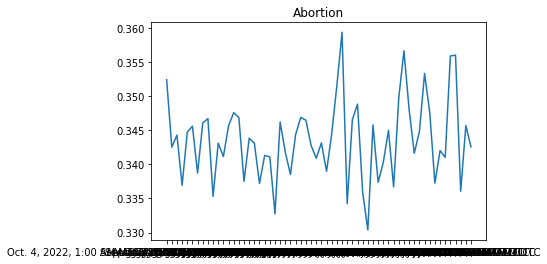

In [122]:
issues = pew.issue
selection = issues[0]

x = data['timestamp']
y = data[selection]

plt.plot(x,y)
plt.title(selection)

Text(0.5, 1.0, 'Gun policy')

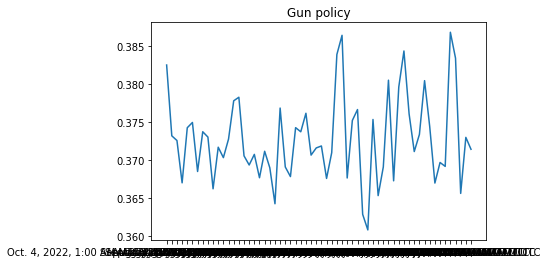

In [141]:
issues = pew.issue
selection = issues[4]

x = data['timestamp']
y = data[selection]

plt.plot(x,y)
plt.title(selection)